## Language Model Training Pipeline


In [1]:
import json
import torch
import evaluate
import transformers
import numpy as np
import pandas as pd
from torch import nn
from torch_lr_finder import LRFinder
import matplotlib as mpl
from pathlib import Path
from tqdm.notebook import tqdm
from datasets import Dataset
from tokenizers import Tokenizer
from tokenizers.normalizers import Sequence, Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder
from transformers import (
    AutoConfig,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    RobertaConfig,
)
from matplotlib import pyplot as plt
import importlib
from sklearn.metrics import roc_curve, auc

In [2]:
torch.cuda.empty_cache()

## Configuration files


In [3]:
seed = 42
batch_size = 32
epochs = 8
learning_rate = 5e-5

data_path = Path("data")
tokenizer_path = data_path / "tokenizer" / "tokenizer.json"
pretrained_output_model_path = data_path / "pretrain_lm"
classifier_output_model_path = data_path / "finetune_lm"

## Prepare data


In [4]:
train_df = pd.read_csv(data_path / "splits" / "finetune_fragment_train.csv")
val_df = pd.read_csv(data_path / "splits" / "finetune_fragment_valid.csv")
train_ds = Dataset.from_dict(train_df)
val_ds = Dataset.from_dict(val_df)

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path.parent)
config = AutoConfig.from_pretrained(pretrained_output_model_path)
config.num_labels = len(set(train_df["label"]))

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_output_model_path, config=config
)
tokenizer.pad_token = tokenizer.eos_token
config.pad_token_id = tokenizer.pad_token_id
model.pad_token_id = tokenizer.pad_token_id
tokenizer.model_max_length = config.n_positions

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at data/pretrain_lm and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def tokenizer_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


train_ds = train_ds.map(tokenizer_function, batched=True)
val_ds = val_ds.map(tokenizer_function, batched=True)

Map:   0%|          | 0/3378 [00:00<?, ? examples/s]

Map:   0%|          | 0/2220 [00:00<?, ? examples/s]

In [7]:
ds_list = [train_ds, val_ds]
ds_list = [ds.remove_columns(["text"]) for ds in ds_list]
ds_list = [ds.rename_column("label", "labels") for ds in ds_list]
[ds.set_format("torch") for ds in ds_list]
train_dl = torch.utils.data.DataLoader(ds_list[0], shuffle=True, batch_size=batch_size)
val_dl = torch.utils.data.DataLoader(ds_list[1], batch_size=batch_size)

In [8]:
# Freeze all layers except the last one
for name, param in model.named_parameters():
    param.requires_grad = False
model.score.weight.requires_grad = True

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(30001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = epochs
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = transformers.get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

## Finetune classifier


In [ ]:
progress_bar = tqdm(range(num_training_steps))
metric = evaluate.load("accuracy")
log_history = []
classifier_output_model_path.mkdir(parents=True, exist_ok=True)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()
    train_loss /= len(train_dl)

    model.eval()
    val_loss = 0
    for batch in val_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits

        # Apply softmax function along the last dimension
        softmax_logits = torch.softmax(logits, dim=-1)

        # Get the predicted class probabilities
        class_probs = softmax_logits[:, 1]  # class 1 is the filler class

        # Round the probabilities to get the predicted class
        predictions = (class_probs > 0.5).float()

        metric.add_batch(predictions=predictions, references=batch["labels"])
        val_loss += outputs.loss.item()
    val_loss /= len(val_dl)

    acc = metric.compute()
    print(
        f"Epoch: {epoch}, TrainLoss: {train_loss:.3f}, ValLoss: {val_loss:.3f}, Accuracy: {acc['accuracy']:.3f}"
    )
    log_history.append(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "accuracy": acc["accuracy"],
        }
    )
    model.save_pretrained(classifier_output_model_path / f"epoch_{epoch}")

with open(classifier_output_model_path / "log_history.json", "w") as fout:
    json.dump(log_history, fout)

## Visualize training curves


In [11]:
with open(classifier_output_model_path / "log_history.json", "r") as f:
    log = json.load(f)

epochs = [metric["epoch"] for metric in log]
train_loss = [metric["train_loss"] for metric in log]
val_loss = [metric["val_loss"] for metric in log]
accuracy = [metric["accuracy"] for metric in log]

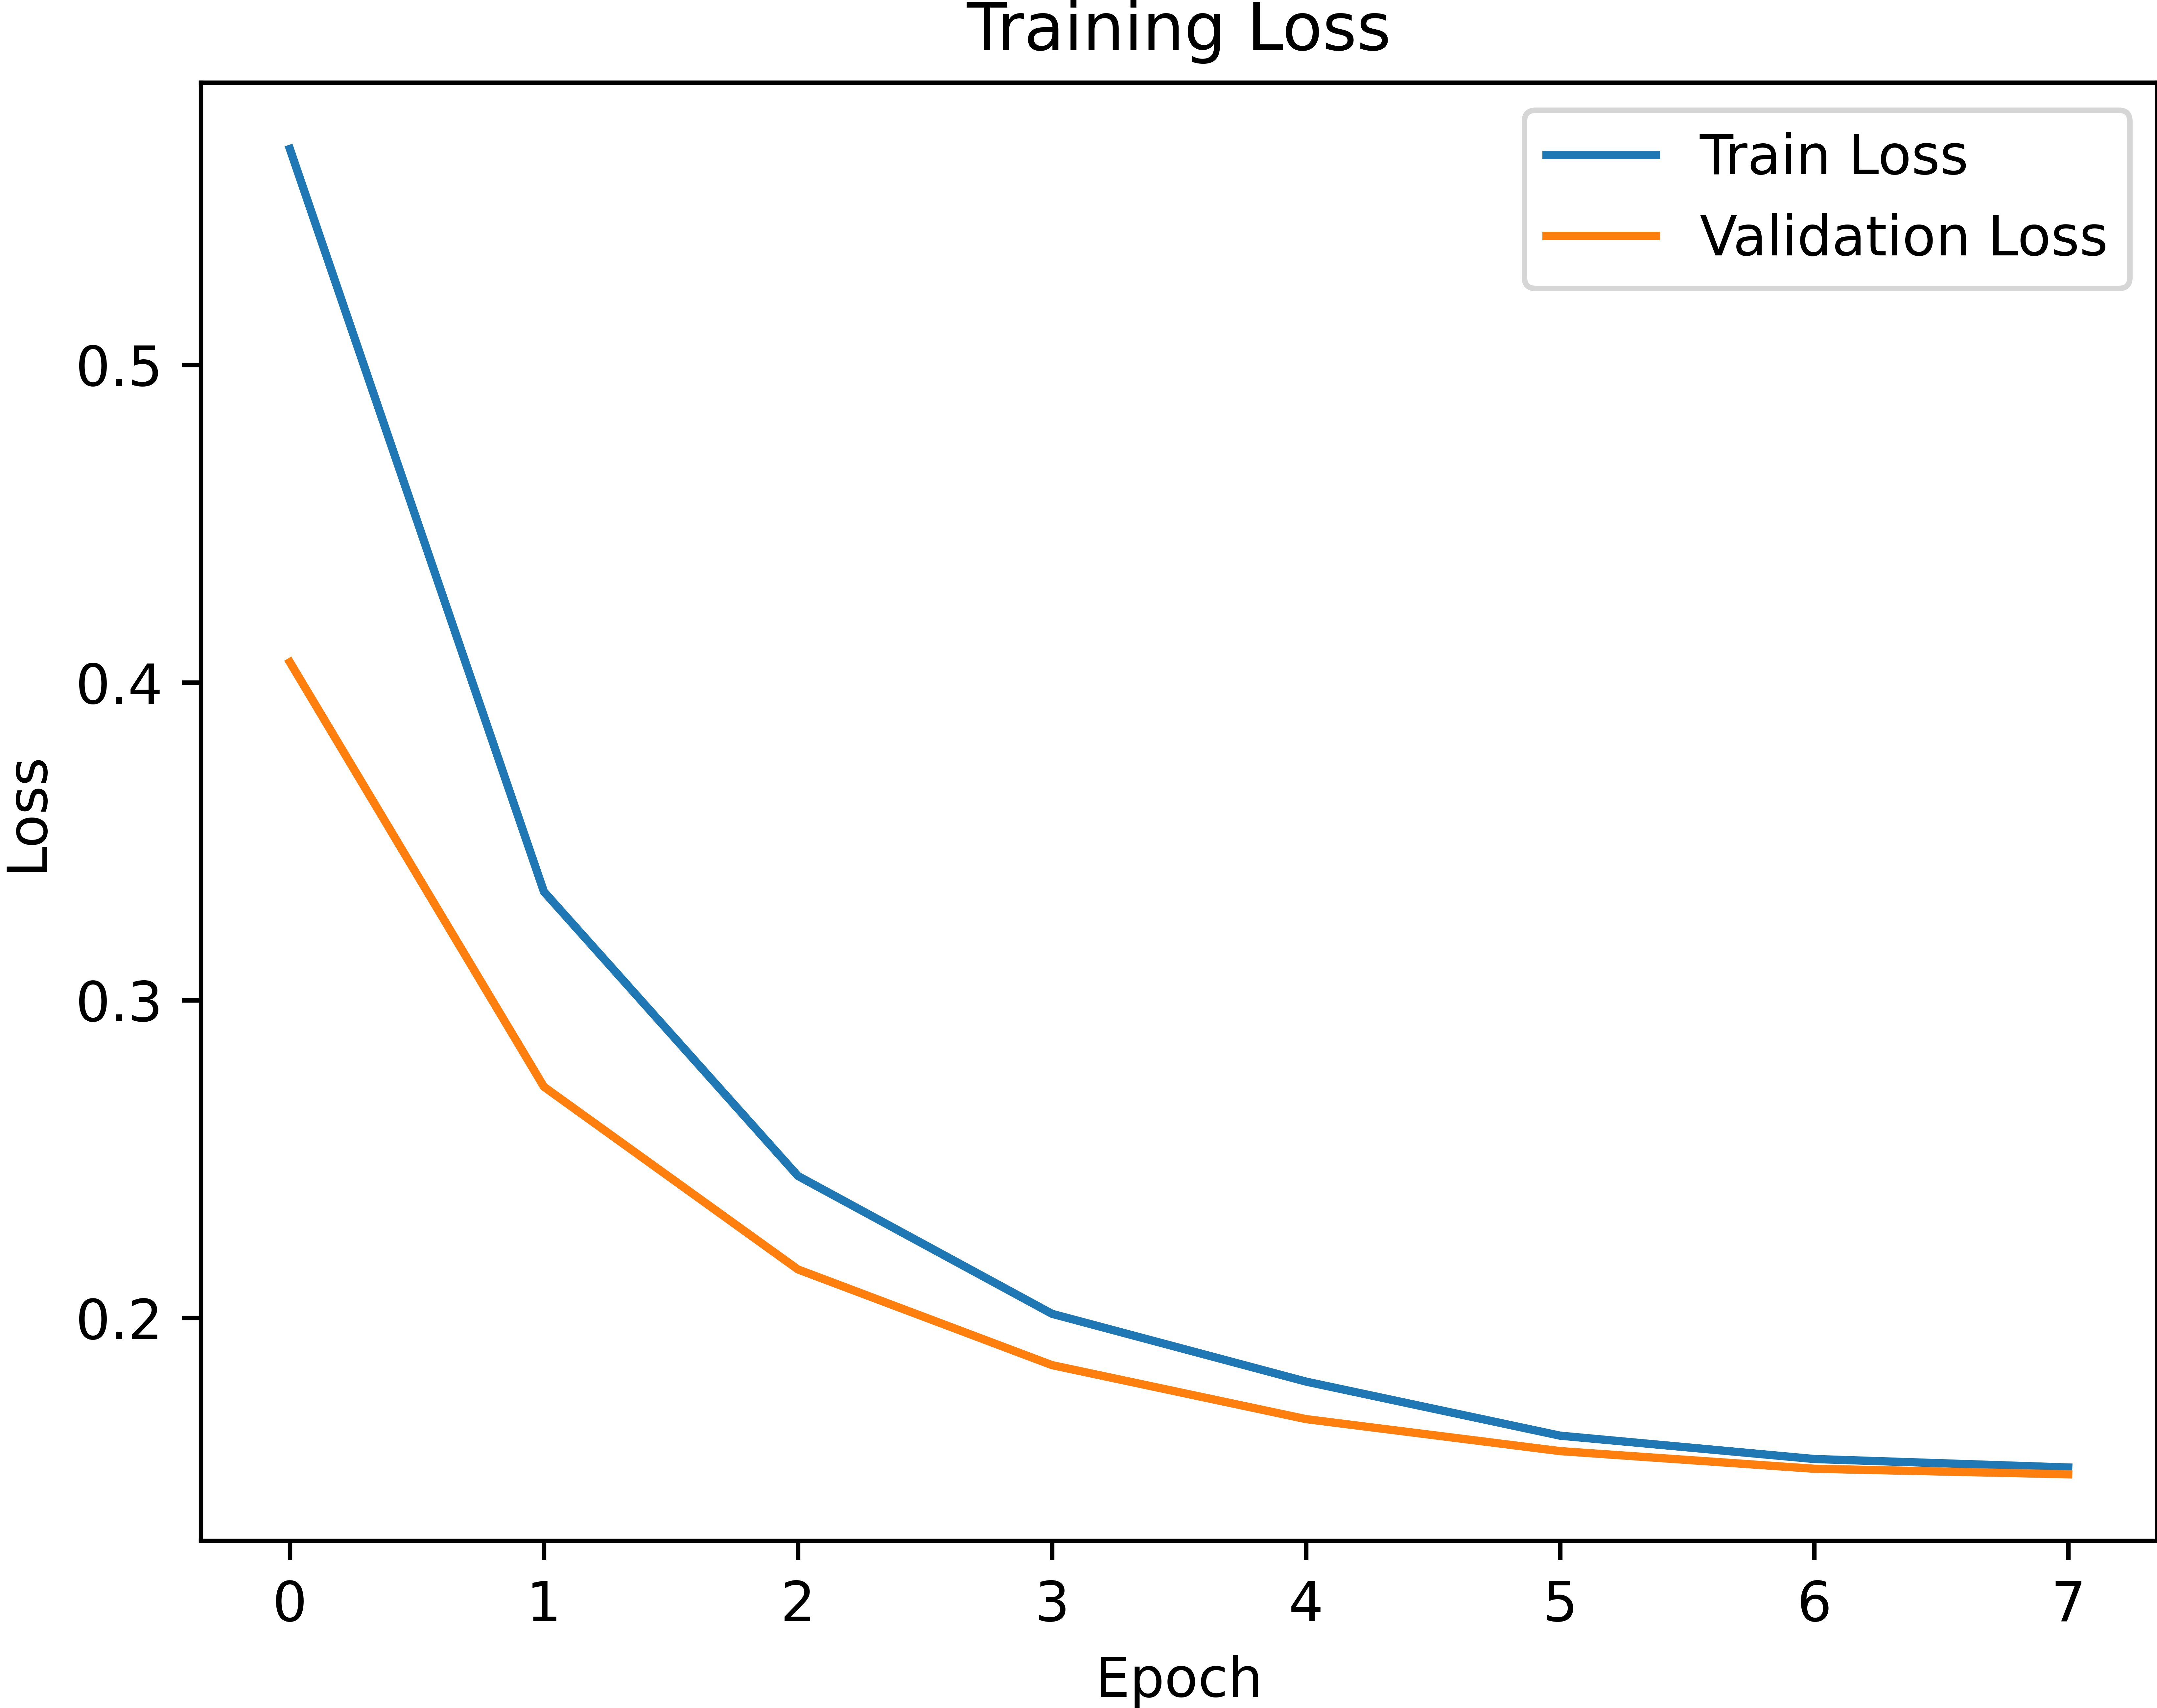

In [12]:
plt.figure(dpi=1200)
mpl.rcParams["savefig.pad_inches"] = 0
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

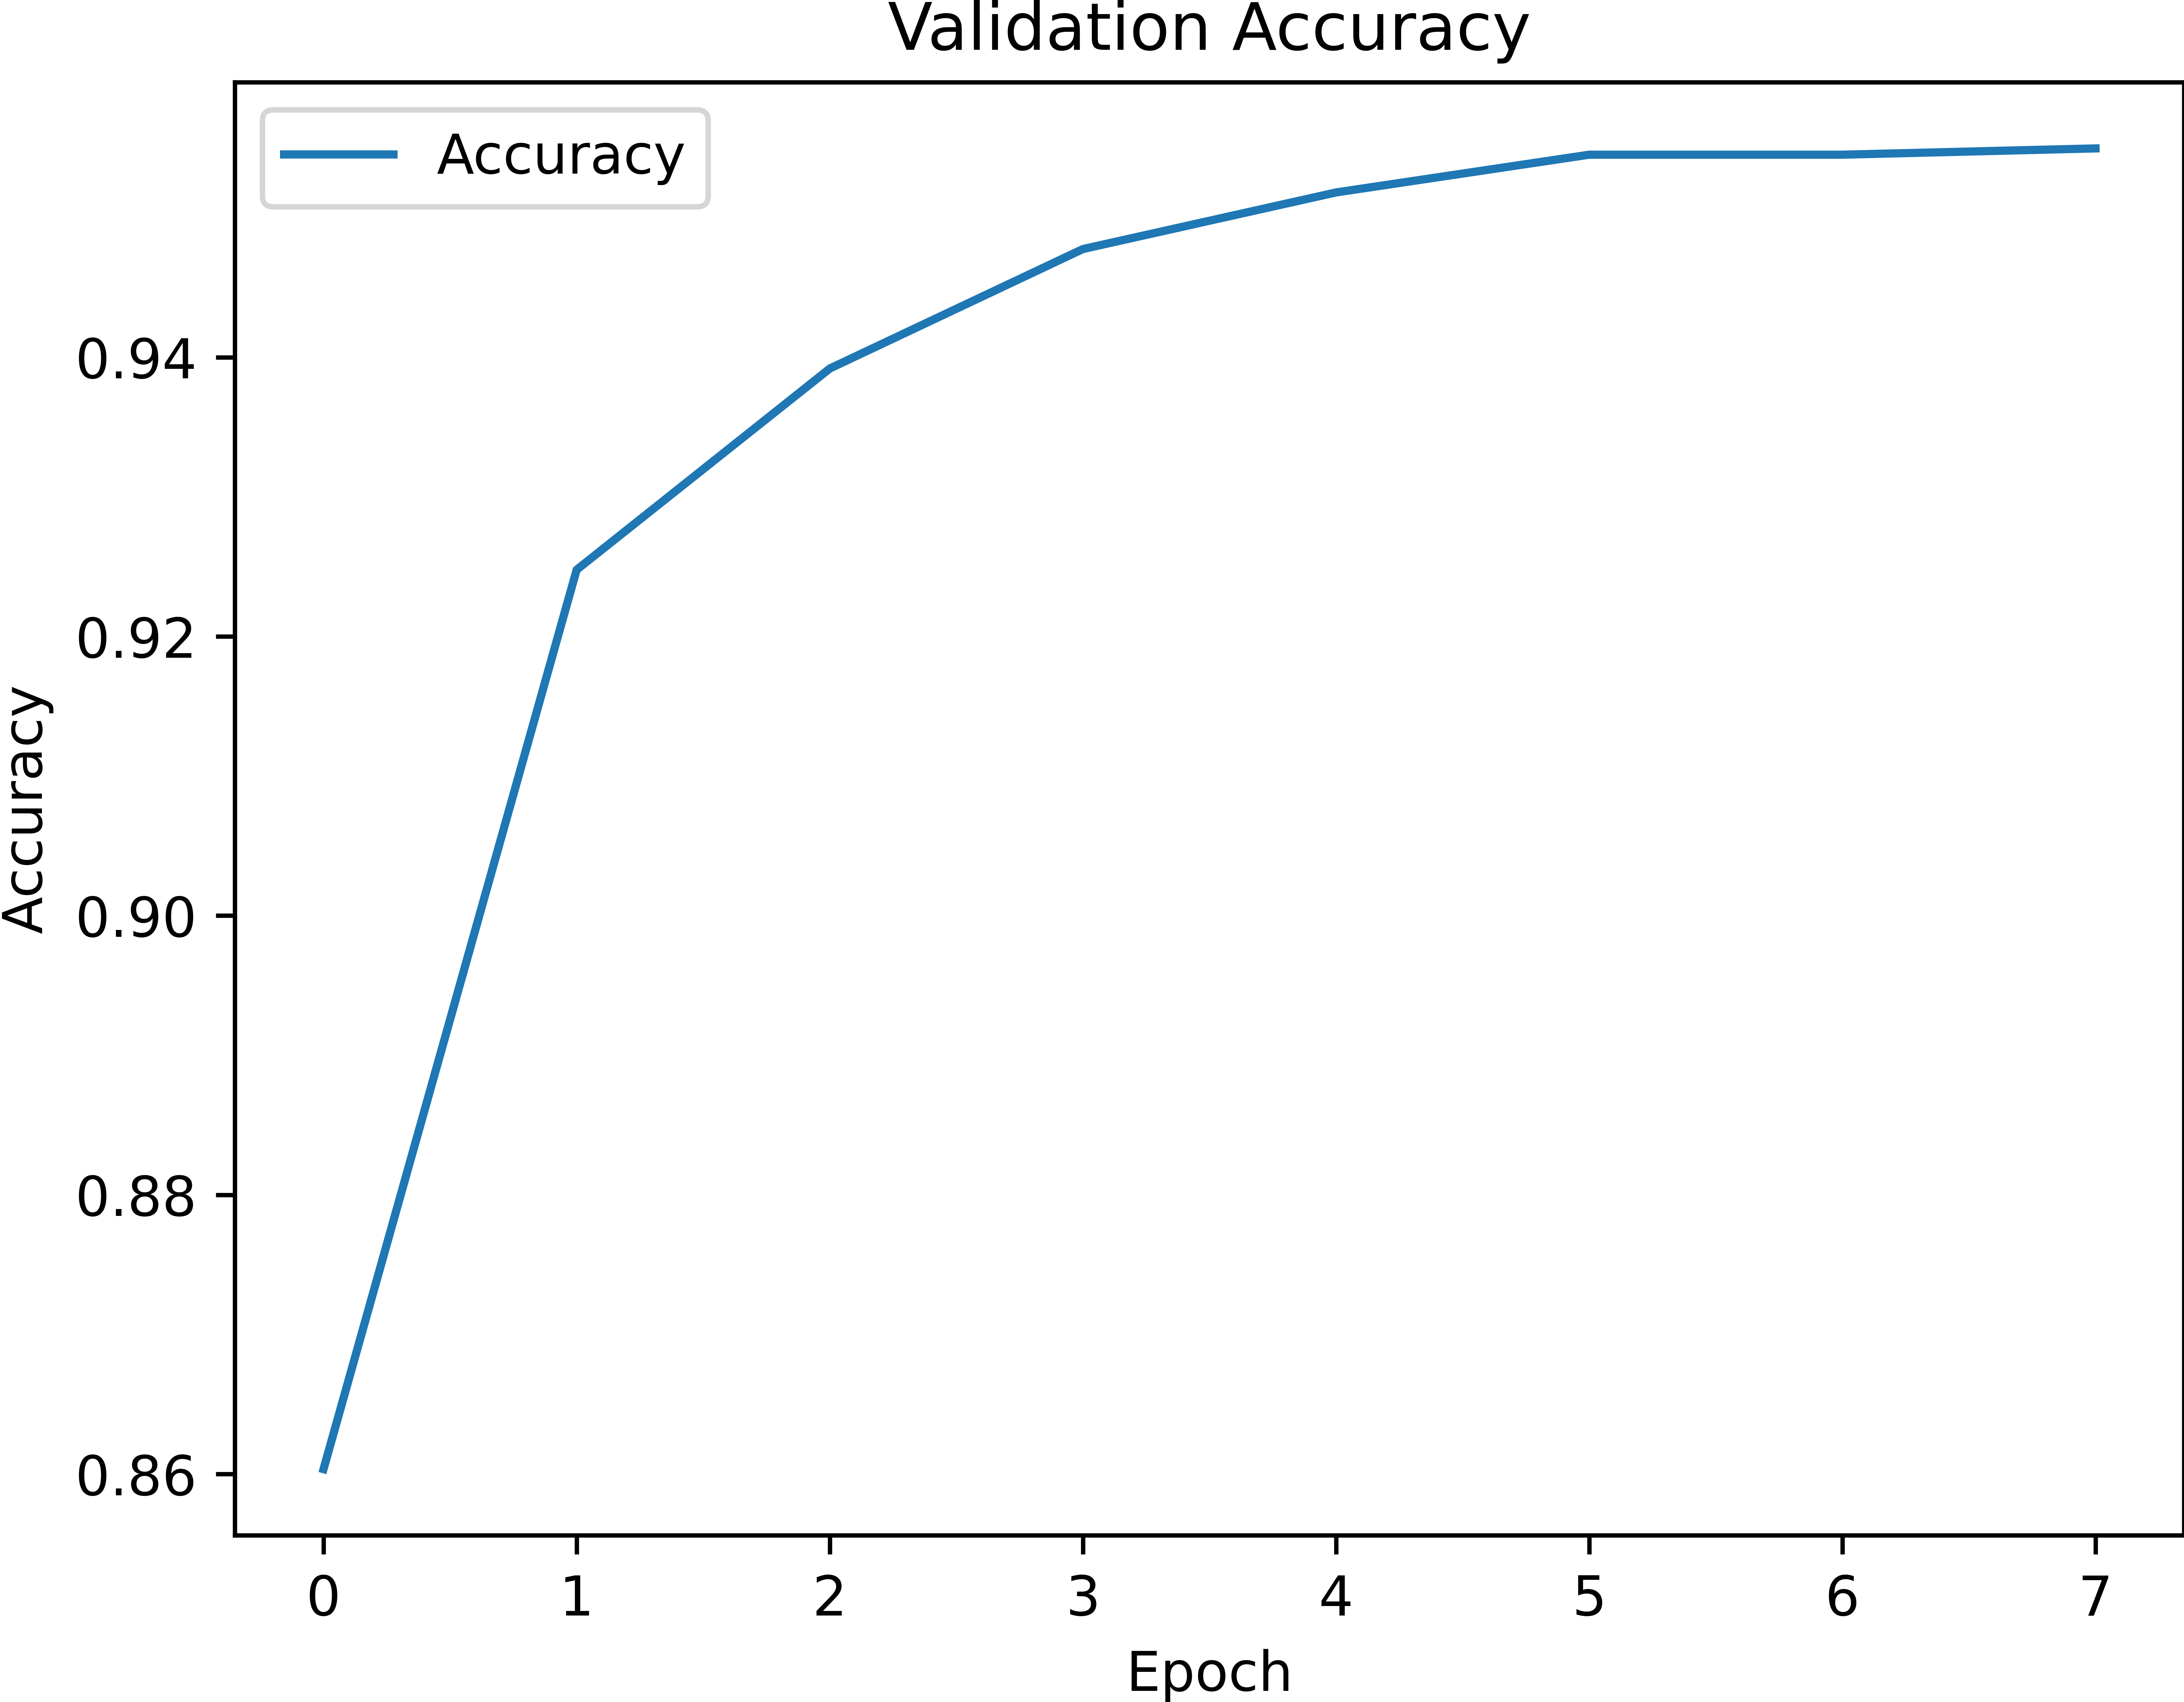

In [13]:
plt.figure(dpi=1200)
mpl.rcParams["savefig.pad_inches"] = 0
plt.plot(epochs, accuracy, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [14]:
print(f"Validation accuracy on fragments = {accuracy[-1]}")

Validation accuracy on fragments = 0.954954954954955


## Create ROC curve


In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    classifier_output_model_path / f"epoch_7"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
metric = evaluate.load("accuracy")

In [16]:
model.eval()
labels = []
probabilities = []
predictions = []

for batch in val_dl:
    batch = {k: v.to(device) for k, v in batch.items()}
    labels.append(batch["labels"])

    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    probability = torch.softmax(logits, dim=1)

    probabilities.append(probability)
    prediction = torch.argmax(logits, dim=-1)
    predictions.append(prediction)

    metric.add_batch(predictions=prediction, references=batch["labels"])

accuracy = metric.compute()["accuracy"]
print(f"Fragment accuracy: {accuracy}")

Fragment accuracy: 0.9477477477477477


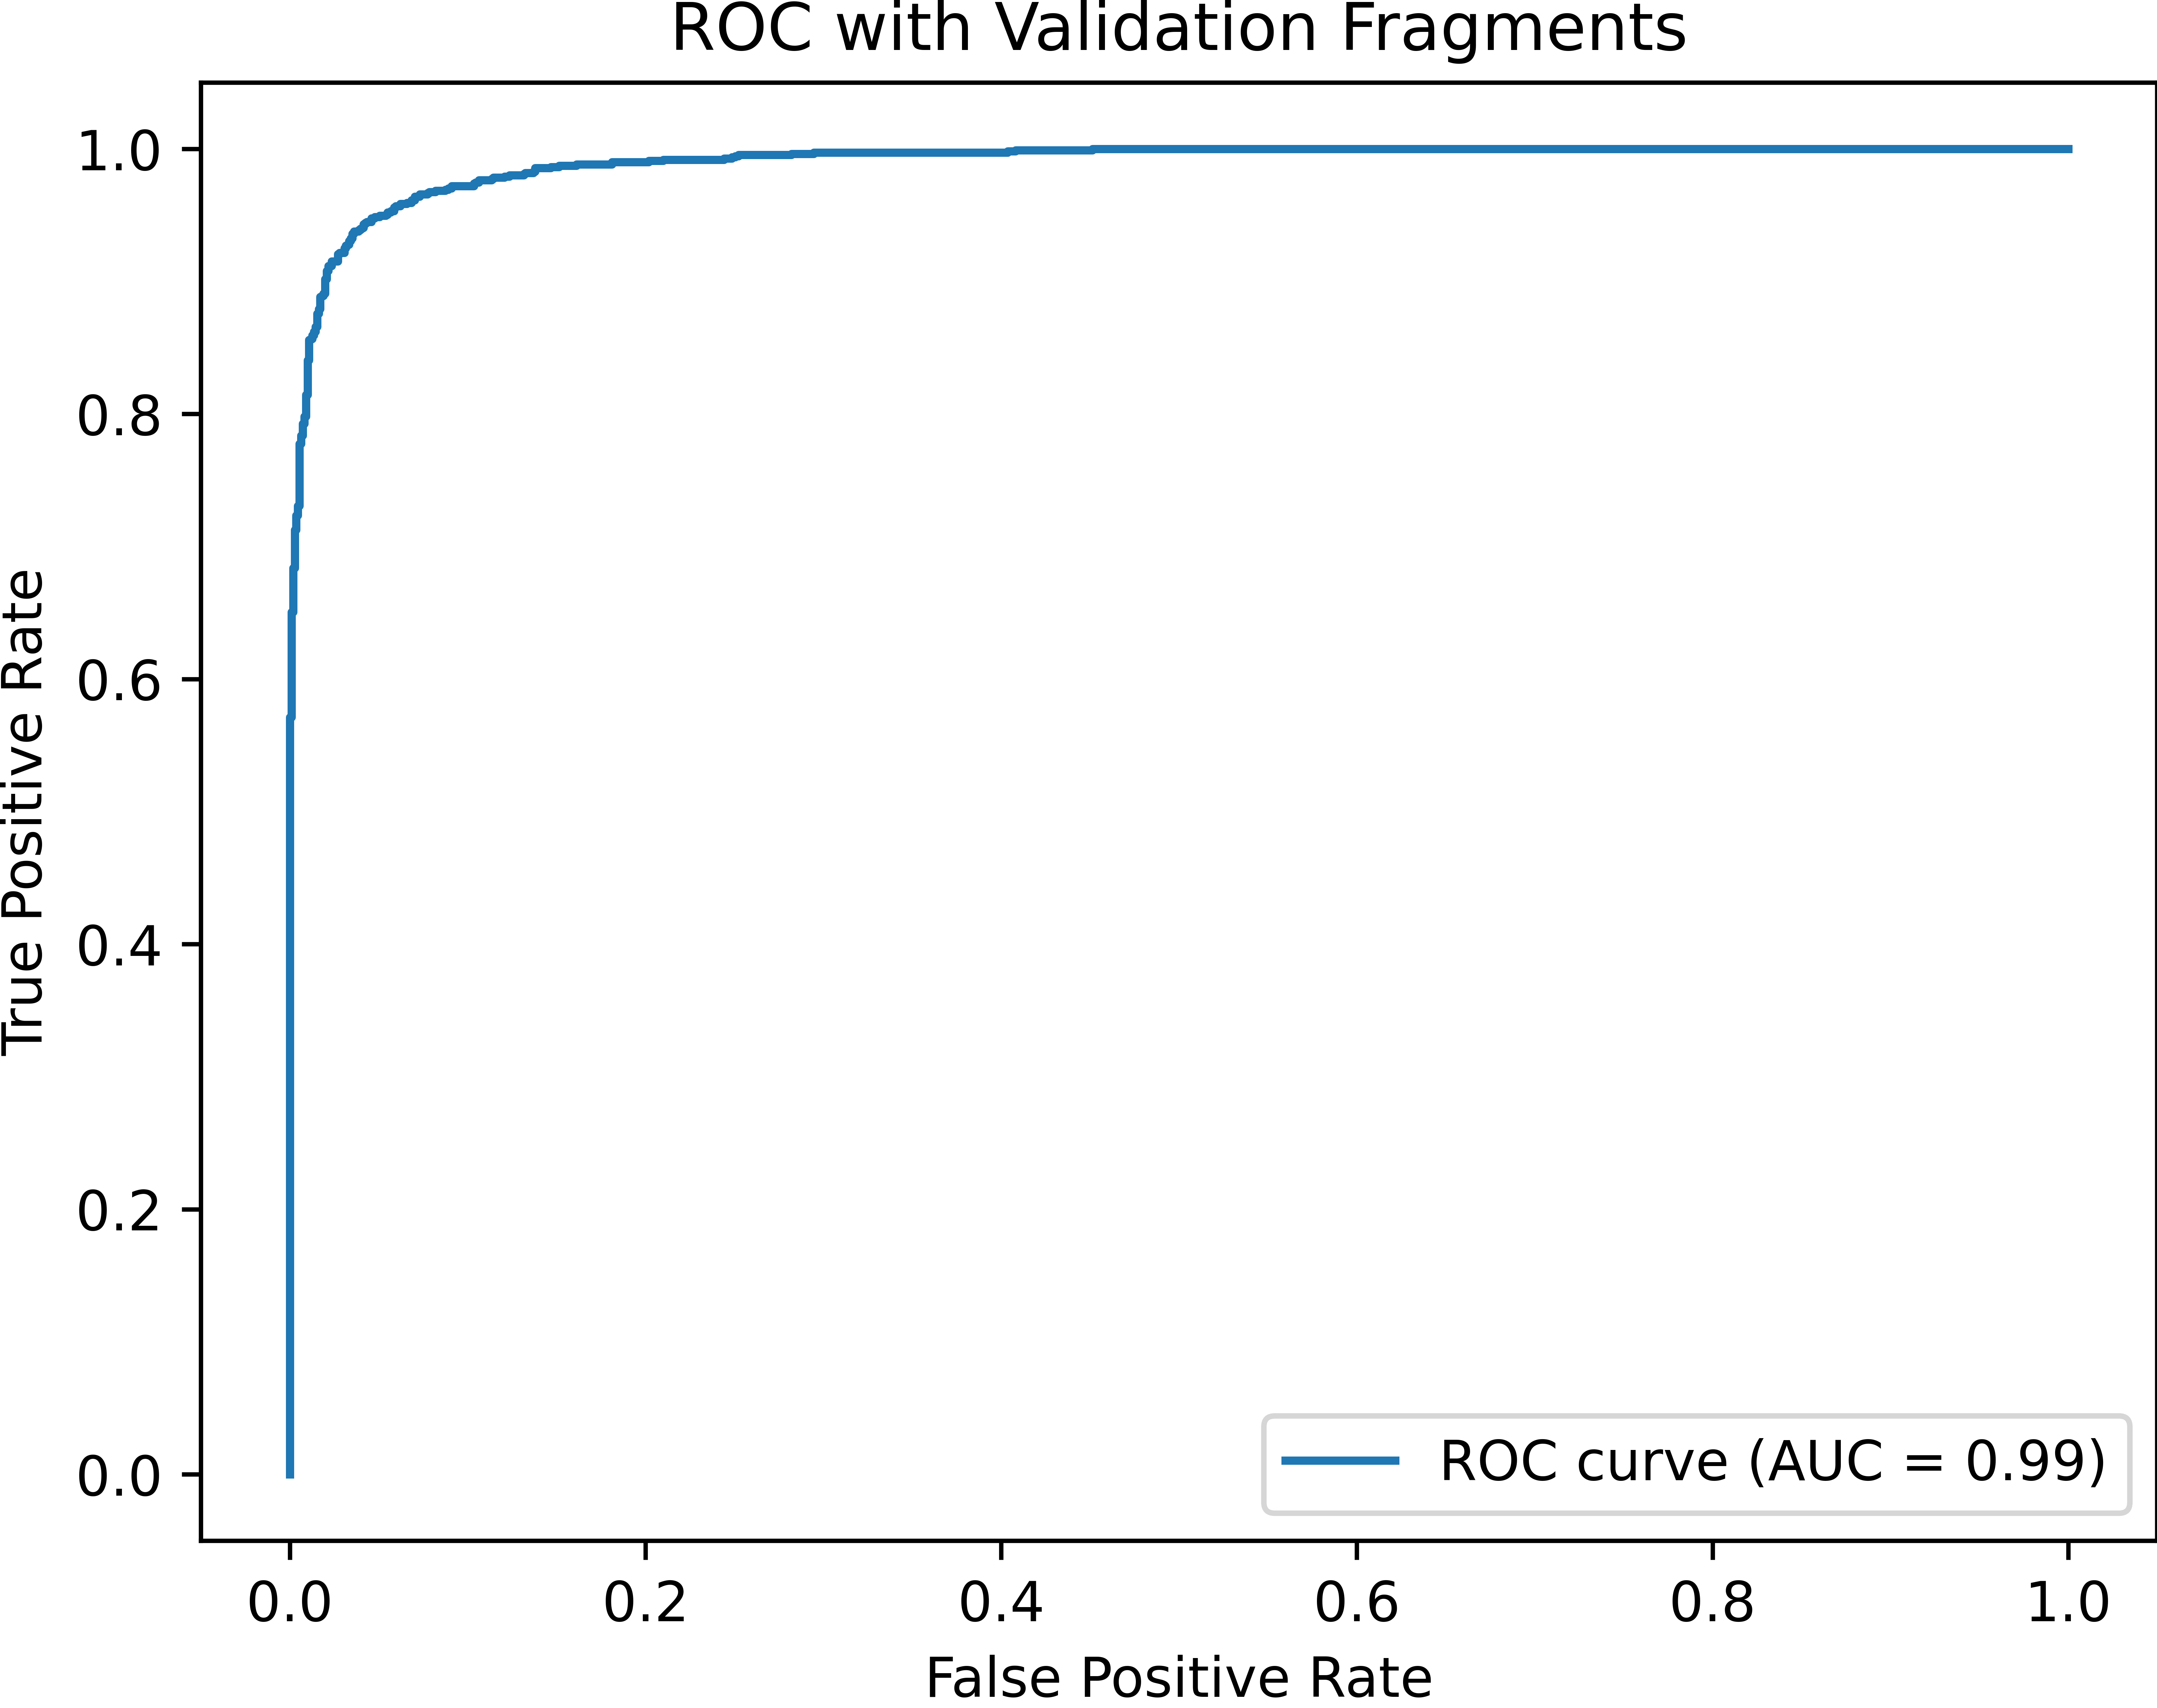

In [17]:
prob = [float(p) for tensor in probabilities for f, p in tensor]
lab = [float(c) for tensor in labels for c in tensor]
fpr, tpr, thresholds = roc_curve(y_true=lab, y_score=prob)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=1200)
mpl.rcParams["savefig.pad_inches"] = 0
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC with Validation Fragments")
plt.legend()
plt.show()